In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score as cvs
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import sklearn.model_selection as skl_ms
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH1 = '/content/drive/My Drive/Data Mining I/Project/Data/final_data1.csv'
df1 = pd.read_csv(DATA_PATH1)

In [ ]:
DATA_PATH2 = '/content/drive/My Drive/Data Mining I/Project/Data/final_data2.csv'
df2 = pd.read_csv(DATA_PATH2)

In [ ]:
rand_state = 42

#Dataset 1

In [ ]:
df1.head()

,country,air pollution,male alcohol consumption,female alcohol consumption,GDP/capita,both suicide rate
0,Lesotho,24.49,8.65,1.67,1270.0,87.48
1,Guyana,23.14,8.57,2.10,9380.0,40.85
2,Eswatini,19.90,14.78,3.26,3680.0,40.46
3,Kiribati,11.07,3.97,0.80,2910.0,30.56
4,Suriname,26.48,11.74,3.10,4440.0,25.89


In [ ]:
X1 = df1.drop(columns=['country', 'both suicide rate'])
y1 = df1['both suicide rate']
norm = MinMaxScaler().fit(X1)
X1_norm = pd.DataFrame(norm.transform(X1))

##Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X1_norm, y1)
coefs = lr_model.coef_
for i, factor in enumerate(X1.columns):
  print(f'{factor}: {coefs[i]}')

air pollution: -2.7611235110844254
male alcohol consumption: 44.77509471509147
female alcohol consumption: -41.3460441364449
GDP/capita: -0.8521423060746329


##kNN

###Hyperparameter optimization

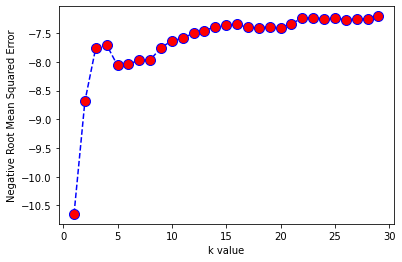

In [ ]:
k_range=range(1, 30)
k_scores=[]
for k in k_range:
    kf_cv = KNeighborsRegressor(n_neighbors=k)
    scores = cvs(kf_cv, X1_norm, y1, cv=10, scoring='neg_root_mean_squared_error')
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.xlabel('k value')
plt.ylabel('Negative Root Mean Squared Error')
plt.show()

##Random Forest

###Hyperparameter optimization

In [ ]:
# define several values for some hyperparameters in a random grid
max_depth = [10, 15, 20, 25, None]
min_samples_leaf = [1, 2, 3, 4, 5]
min_samples_split = [2, 3, 4, 5, 6]
n_estimators = [100, 200, 300, 400, 500]

random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators}

In [ ]:
# use cross validation to find the best hyperparameters
model = RandomForestRegressor()
CV = RandomizedSearchCV(estimator=model, param_distributions=random_grid, cv=5, random_state=rand_state, scoring='neg_root_mean_squared_error')
CV.fit(X1, y1)
rf_model = CV.best_estimator_
rf_model

RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=3)

###Feature importance

In [ ]:
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance
                       in zip(X1.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: air pollution                            Importance: 0.33
Feature: GDP/capita                               Importance: 0.31
Feature: female alcohol consumption               Importance: 0.2
Feature: male alcohol consumption                 Importance: 0.15


##Model selection

In [ ]:
lr_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=4)
rf_model = RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=4)
models = [lr_model, knn_model, rf_model]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to d

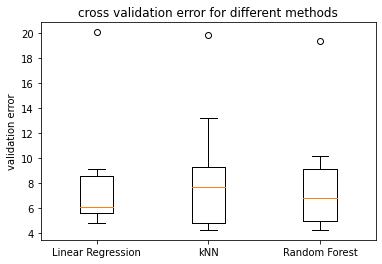

Root Mean Squared Error for Linear Regression: 7.9919
Root Mean Squared Error for KNN: 8.4759
Root Mean Squared Error for Random Forest: 7.9583


In [ ]:
k_fold = 10
RMSE = np.zeros((k_fold, len(models)))
cv = skl_ms.KFold(n_splits=k_fold, random_state=rand_state, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X1)):
  X_train, X_val = X1.iloc[train_index], X1.iloc[val_index]
  X_norm_train, X_norm_val = X1_norm.iloc[train_index], X1_norm.iloc[val_index]
  y_train, y_val = y1.iloc[train_index], y1.iloc[val_index]

  for m in range(np.shape(models)[0]):
    model = models[m]
    if m == 2: # Random Forest
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
    else: # Linear Regression and kNN
      model.fit(X_norm_train, y_train)
      y_pred = model.predict(X_norm_val)
    RMSE[i, m] = np.sqrt(mean_squared_error(y_val, y_pred))

plt.boxplot(RMSE)
plt.title('cross validation error for different methods')
plt.xticks(np.arange(len(models))+1, ('Linear Regression', 'kNN', 'Random Forest'))
plt.ylabel('validation error')
plt.show()

# print average misclassification error for each model
print('Root Mean Squared Error for Linear Regression: %.4f'
%np.mean(RMSE[:, 0]))
print('Root Mean Squared Error for KNN: %.4f'
%np.mean(RMSE[:, 1]))
print('Root Mean Squared Error for Random Forest: %.4f'
%np.mean(RMSE[:, 2]))

#Dataset 2

In [ ]:
df2.head()

,Unnamed: 0,country,gender,air pollution,alcohol consumption,GDP/capita,suicide rate
0,0,Antigua and Barbuda,MLE,21.03,15.09,14900.0,0.00
1,1,Barbados,FMLE,24.82,4.35,16720.0,0.16
2,2,Barbados,MLE,24.82,16.95,16720.0,0.49
3,3,Grenada,MLE,22.87,14.25,9630.0,0.53
4,4,Antigua and Barbuda,FMLE,21.03,4.25,14900.0,0.60


In [ ]:
X2 = df2.drop(columns=['Unnamed: 0', 'country', 'suicide rate'])
y2 = df2['suicide rate']
gender_code = {'FMLE': 0, 'MLE': 1}
X2.gender = [gender_code[item] for item in X2.gender]
norm = MinMaxScaler().fit(X2)
X2_norm = pd.DataFrame(norm.transform(X2))

##Linear Regression

In [ ]:
lr_model = LinearRegression()
lr_model.fit(X2_norm, y2)
coefs = lr_model.coef_
for i, factor in enumerate(X2.columns):
  print(f'{factor}: {coefs[i]}')

gender: 9.09477346617719
air pollution: -1.908405998246077
alcohol consumption: 9.576212703519918
GDP/capita: -8.897373978536171


##kNN

###Hyperparameter optimization

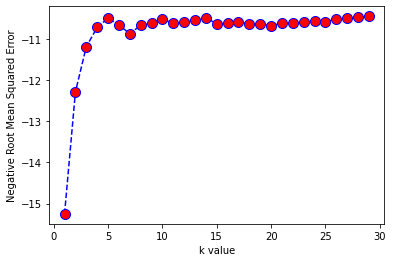

In [ ]:
k_range=range(1, 30)
k_scores=[]
for k in k_range:
    kf_cv = KNeighborsRegressor(n_neighbors=k)
    scores = cvs(kf_cv, X2_norm, y2, cv=10, scoring='neg_root_mean_squared_error')
    k_scores.append(scores.mean())
plt.plot(k_range, k_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.xlabel('k value')
plt.ylabel('Negative Root Mean Squared Error')
plt.show()

##Random Forest

###Hyperparameter optimization

In [ ]:
# define several values for some hyperparameters in a random grid
max_depth = [10, 15, 20, 25, None]
min_samples_leaf = [1, 2, 3, 4, 5]
min_samples_split = [2, 3, 4, 5, 6]
n_estimators = [100, 200, 300, 400, 500]

random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'n_estimators': n_estimators}

In [ ]:
# use cross validation to find the best hyperparameters
model = RandomForestRegressor()
CV = RandomizedSearchCV(estimator=model, param_distributions=random_grid, cv=5, random_state=rand_state, scoring='neg_root_mean_squared_error')
CV.fit(X2, y2)
rf_model = CV.best_estimator_
rf_model

RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=3)

###Feature importance

In [ ]:
importances = list(rf_model.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance
                       in zip(X2.columns, importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Feature: {:40} Importance: {}'.format(*pair)) for pair in feature_importances];

Feature: gender                                   Importance: 0.38
Feature: alcohol consumption                      Importance: 0.24
Feature: GDP/capita                               Importance: 0.22
Feature: air pollution                            Importance: 0.17


##Model selection

In [ ]:
lr_model = LinearRegression()
knn_model = KNeighborsRegressor(n_neighbors=5)
rf_model = RandomForestRegressor(max_depth=25, min_samples_leaf=5, min_samples_split=4)
models = [lr_model, knn_model, rf_model]

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to d

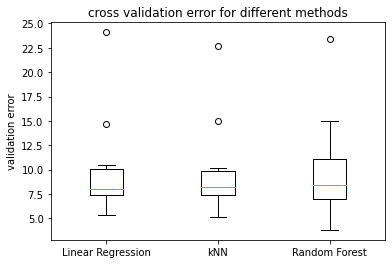

Root Mean Squared Error for Linear Regression: 10.0644
Root Mean Squared Error for KNN: 9.9780
Root Mean Squared Error for Random Forest: 10.0652


In [ ]:
k_fold = 10
RMSE = np.zeros((k_fold, len(models)))
cv = skl_ms.KFold(n_splits=k_fold, random_state=rand_state, shuffle=True)

for i, (train_index, val_index) in enumerate(cv.split(X2)):
  X_train, X_val = X2.iloc[train_index], X2.iloc[val_index]
  X_norm_train, X_norm_val = X2_norm.iloc[train_index], X2_norm.iloc[val_index]
  y_train, y_val = y2.iloc[train_index], y2.iloc[val_index]

  for m in range(np.shape(models)[0]):
    model = models[m]
    if m == 2: # Random Forest
      model.fit(X_train, y_train)
      y_pred = model.predict(X_val)
    else: # Linear Regression and kNN
      model.fit(X_norm_train, y_train)
      y_pred = model.predict(X_norm_val)
    RMSE[i, m] = np.sqrt(mean_squared_error(y_val, y_pred))

plt.boxplot(RMSE)
plt.title('cross validation error for different methods')
plt.xticks(np.arange(len(models))+1, ('Linear Regression', 'kNN', 'Random Forest'))
plt.ylabel('validation error')
plt.show()

# print average misclassification error for each model
print('Root Mean Squared Error for Linear Regression: %.4f'
%np.mean(RMSE[:, 0]))
print('Root Mean Squared Error for KNN: %.4f'
%np.mean(RMSE[:, 1]))
print('Root Mean Squared Error for Random Forest: %.4f'
%np.mean(RMSE[:, 2]))